In [26]:
import warnings

warnings.filterwarnings("ignore")

import sys

# 配置搜索路径
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import backtrader as bt
import pandas as pd
import pprint
import sqlite3
from tqdm import tqdm
from datetime import datetime
from strategies import CustomMLStrategy
from backtest_utils import CustomCommissionSchema, CustomAnalyzer
from Share.database.downloader.downloader_base import DownloaderBase
import Share.database.database_config as db_config

In [27]:
BACKTEST_INITIAL_CASH = 100000  # 初始化资金
BACKTEST_INDEX_SYMBOLS = "000016"  # 【选股】策略的对比基准=指数index，【择时】策略的对比基准=单股自身

# 读取模型预测文件
model_pred_df = pd.read_pickle("./backtest_data/stock_selection_result.pkl")
# 构建数据里表
BACKTEST_STOCK_SYMBOLS = model_pred_df['stock_code'].map(lambda x: str(x).zfill(6)).unique().tolist()
BACKTEST_START_DATE = datetime.strptime(model_pred_df['datetime'].min(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测开始日期
BACKTEST_END_DATE = datetime.strptime(model_pred_df['datetime'].max(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测结束日期
print(f'Start: {BACKTEST_START_DATE}, End: {BACKTEST_END_DATE}')

Start: 20200102, End: 20200331


In [28]:
# 初始化db_downloader
db_conn = sqlite3.connect("../../Share/database/hh_quant.db")
db_downloader = DownloaderBase(db_conn=db_conn, db_config=db_config)

In [29]:
cerebro = bt.Cerebro()

In [30]:
print("开始设置回测基础参数...")
cerebro.broker.setcash(BACKTEST_INITIAL_CASH)  # 配置初始资金量
cerebro.broker.addcommissioninfo(CustomCommissionSchema())  # 配置自定义的佣金类型

开始设置回测基础参数...


In [31]:
print("开始添加回测股票数据...")
for stock_symbol in tqdm(BACKTEST_STOCK_SYMBOLS):
    stock_data = db_downloader._download_stock_history_info(stock_symbol, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
    if not stock_data.empty:
        stock_data = stock_data[["datetime", "open", "high", "low", "close", "volume"]]
        stock_data["datetime"] = pd.to_datetime(stock_data["datetime"])
        stock_data.set_index("datetime", inplace=True)
        stock_data_feeds = bt.feeds.PandasData(dataname=stock_data)  # 构建回测数据Feeds流
        cerebro.adddata(stock_data_feeds, name=stock_symbol)  # 添加回测数据

开始添加回测股票数据...


100%|██████████| 45/45 [00:00<00:00, 123.86it/s]


In [32]:
print("开始添加基准数据...")
benchmark_data = db_downloader._download_index_history_info(BACKTEST_INDEX_SYMBOLS, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
benchmark_data = benchmark_data[["datetime", "open", "high", "low", "close", "volume"]]
benchmark_data["datetime"] = pd.to_datetime(benchmark_data["datetime"])
benchmark_data.set_index("datetime", inplace=True)
benchmark_name = f"benchmark_{BACKTEST_INDEX_SYMBOLS}"
benchmark_data_feeds = bt.feeds.PandasData(dataname=benchmark_data)  # 构建基准数据Feeds流
cerebro.adddata(benchmark_data_feeds, name=benchmark_name)  # 添加基准数据

开始添加基准数据...


In [33]:
print("开始添加策略...")
strategy_params = {
        "model_prediction_file": "./backtest_data/stock_selection_result.pkl",
        "benchmark": benchmark_name
    }
cerebro.addstrategy(CustomMLStrategy, **strategy_params)

开始添加策略...


0

In [34]:
print("开始添加分析器...")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")  # 添加最大回撤的分析器，后续customAnalyzer中需要用到
cerebro.addanalyzer(CustomAnalyzer, _name="custom_analyzer")  # 添加自定义的分析器

开始添加分析器...


In [35]:
print("开始添加观察器...")
cerebro.addobserver(bt.observers.Benchmark, data=benchmark_data_feeds, timeframe=bt.TimeFrame.NoTimeFrame)  # 添加基准对比观察器

开始添加观察器...


In [36]:
print("开始运行回测...")
# 运行回测
results = cerebro.run()
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

开始运行回测...
启动基准对比...
2020-01-15 订单取消/保证金不足/拒绝
2020-01-15 买入执行, 引用: 198, 价格: 8.08, 成本: 46088.32, 手续费: 5.00, 数量: 5704.00, 股票: 600050
2020-01-15 买入执行, 引用: 199, 价格: 44.95, 成本: 48725.80, 手续费: 5.00, 数量: 1084.00, 股票: 601601
2020-01-16 买入执行, 引用: 201, 价格: 82.95, 成本: 1327.20, 手续费: 5.00, 数量: 16.00, 股票: 601899
2020-01-16 买入执行, 引用: 202, 价格: 448.25, 成本: 2241.25, 手续费: 5.00, 数量: 5.00, 股票: 600406
2020-01-16 ATR 触发止损... 执行平仓【股票: 601601】, 购入价格: 44.95, 止损价格: 43.99467721782591】
2020-01-16 ATR 触发止损... 执行平仓【股票: 600050】, 购入价格: 8.08, 止损价格: 7.898754685547688】
2020-01-16 ATR 触发止损... 执行平仓【股票: 600406】, 购入价格: 448.25, 止损价格: 436.9517992503124】
2020-01-17 卖出执行, 引用: 203, 价格: 44.05, 成本: 48725.80, 手续费: 47.89, 数量: -1084.00, 股票: 601601
2020-01-17 卖出执行, 引用: 204, 价格: 7.85, 成本: 46088.32, 手续费: 44.91, 数量: -5704.00, 股票: 600050
2020-01-17 卖出执行, 引用: 205, 价格: 431.15, 成本: 2241.25, 手续费: 5.00, 数量: -5.00, 股票: 600406
2020-01-17 买入执行, 引用: 206, 价格: 293.00, 成本: 586.00, 手续费: 5.00, 数量: 2.00, 股票: 600809
2020-01-17 操作盈亏, 毛利润: -975.60, 净利润: -102

In [37]:
print("开始打印回测相关指标...")
custom_analysis = results[0].analyzers.custom_analyzer.get_analysis()
format_analysis_result = {"基准": {}, "策略": {}, "其他": {}}
for key, value in custom_analysis.items():
    if key.startswith("基准"):
        format_analysis_result["基准"][key] = round(value, 4)
    elif key.startswith("策略"):
        format_analysis_result["策略"][key] = round(value, 4)
    else:
        format_analysis_result["其他"][key] = round(value, 4)
pprint.pprint(format_analysis_result)

开始打印回测相关指标...
{'其他': {'亏损次数': 43,
        '夏普比率': -0.8267,
        '日均超额收益': 0.0015,
        '日胜率': 0.4035,
        '最大回撤': 10.9979,
        '最大回撤区间': 27,
        '盈亏比': 1.397,
        '盈利次数': 18,
        '索提诺比率': -1.0208,
        '胜率': 0.2951,
        '贝塔': 0.6955,
        '超额收益': 0.0772,
        '超额收益夏普比率': 2.0731,
        '阿尔法': 0.0008},
 '基准': {'基准年化收益': -0.4536, '基准收益': -0.1299, '基准波动率': 0.2857},
 '策略': {'策略年化收益': -0.2096, '策略收益': -0.0527, '策略波动率': 0.251}}


In [38]:
strategy_returns = results[0].analyzers.custom_analyzer.get_strategy_returns()
benchmark_returns = results[0].analyzers.custom_analyzer.get_benchmark_returns()

In [39]:
strategy_returns = pd.Series(strategy_returns)
benchmark_returns = pd.Series(benchmark_returns)

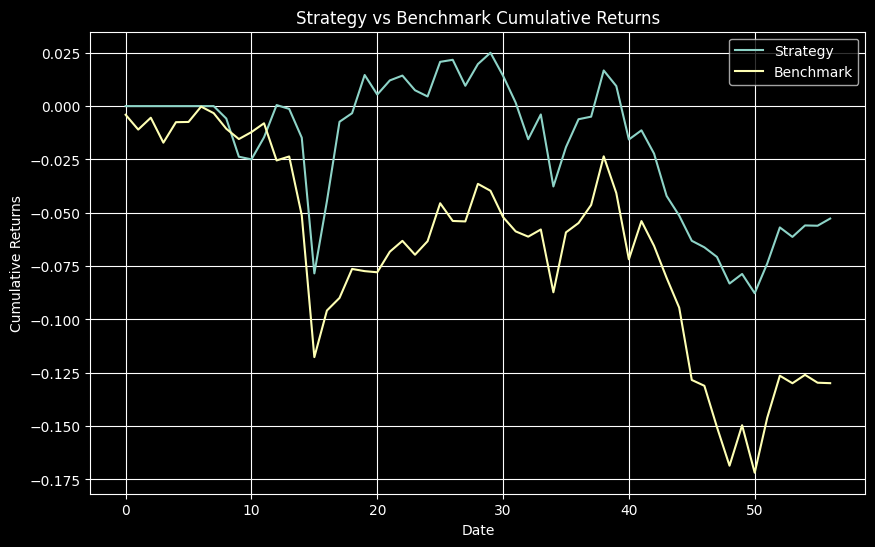

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设你的日收益率数据是这样的
# strategy_returns = pd.Series(...)
# benchmark_returns = pd.Series(...)

# 检查index是否一致以保证对齐
# if not strategy_returns.index.equals(benchmark_returns.index):
#     raise ValueError("Indexes of strategy_returns and benchmark_returns must match")

# 计算累积收益率
strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1
benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1

# 绘制累积收益率曲线
plt.figure(figsize=(10, 6))
plt.plot(strategy_cumulative_returns, label='Strategy')
plt.plot(benchmark_cumulative_returns, label='Benchmark')

# 添加标题和标签
plt.title('Strategy vs Benchmark Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')

# 显示图例
plt.legend()

# 显示网格
plt.grid(True)

# 显示绘制的图形
plt.show()
